### Import Library

In [ ]:
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

### Import Train and Test sets

In [ ]:
train_set = pd.read_csv('6Hsampled_data_set/SARA/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10 
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/SARA/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10 
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10 
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/SARA/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10 
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10 
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

### Tuning Parameters

In [ ]:
order = (1, 0, 2)
seasonal_order = (1, 0, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 1, 2)
exog_order['WindSpeed'] = (1, 1, 2)
exog_order['WindDirSin'] = (1, 1, 1)
exog_order['WindDirCos'] = (2, 0, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 0, 1, 1461)
exog_seasonal_order['WindSpeed'] = (1, 1, 0, 1461)
exog_seasonal_order['WindDirSin'] = (1, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

### Initialize model

In [ ]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

### Train exogenous models

In [ ]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        n_iter = 1
        if exog=='WindSpeed': n_iter=10
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=n_iter, learn=True, verbose=1)

100%|██████████| 4383/4383 [05:09<00:00, 14.17it/s]


ITER#0  RMSE:5.590021818010834


100%|██████████| 4383/4383 [04:57<00:00, 14.75it/s]


ITER#0  RMSE:15.203341468370875


100%|██████████| 4383/4383 [05:01<00:00, 14.53it/s]


ITER#1  RMSE:14.81748242619024


100%|██████████| 4383/4383 [04:51<00:00, 15.02it/s]


ITER#2  RMSE:14.526651176296651


100%|██████████| 4383/4383 [04:28<00:00, 16.32it/s]


ITER#3  RMSE:14.345165237789953


100%|██████████| 4383/4383 [04:25<00:00, 16.50it/s]


ITER#4  RMSE:14.189729526229783


100%|██████████| 4383/4383 [04:27<00:00, 16.37it/s]


ITER#5  RMSE:14.036748670683497


100%|██████████| 4383/4383 [04:24<00:00, 16.54it/s]


ITER#6  RMSE:13.87857750233431


100%|██████████| 4383/4383 [04:06<00:00, 17.78it/s]


ITER#7  RMSE:13.712271436825928


100%|██████████| 4383/4383 [04:51<00:00, 15.06it/s]


ITER#8  RMSE:13.535693871427034


100%|██████████| 4383/4383 [04:56<00:00, 14.79it/s]


ITER#9  RMSE:13.349262652309383


100%|██████████| 4383/4383 [04:46<00:00, 15.32it/s]


ITER#0  RMSE:9.873003692554079


100%|██████████| 4383/4383 [05:01<00:00, 14.53it/s]

ITER#0  RMSE:9.382025696460358


### Train PM2.5 model with exogenous models

In [10]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [16:58<00:00,  4.30it/s]


ITER#0  RMSE:14.88920239734506


100%|██████████| 4383/4383 [18:20<00:00,  3.98it/s]


ITER#1  RMSE:14.560436132211949


100%|██████████| 4383/4383 [18:13<00:00,  4.01it/s]


ITER#2  RMSE:13.772548528444336


100%|██████████| 4383/4383 [18:09<00:00,  4.02it/s]


ITER#3  RMSE:13.140694005477746


100%|██████████| 4383/4383 [17:20<00:00,  4.21it/s]


ITER#4  RMSE:12.776840639193518


100%|██████████| 4383/4383 [16:31<00:00,  4.42it/s]


ITER#5  RMSE:12.63982292038583


100%|██████████| 4383/4383 [17:32<00:00,  4.17it/s]


ITER#6  RMSE:12.608239101567483


100%|██████████| 4383/4383 [15:32<00:00,  4.70it/s]


ITER#7  RMSE:12.604381937599342


100%|██████████| 4383/4383 [15:15<00:00,  4.79it/s]


ITER#8  RMSE:12.603596010331287


100%|██████████| 4383/4383 [15:15<00:00,  4.79it/s]

ITER#9  RMSE:12.601472044079692


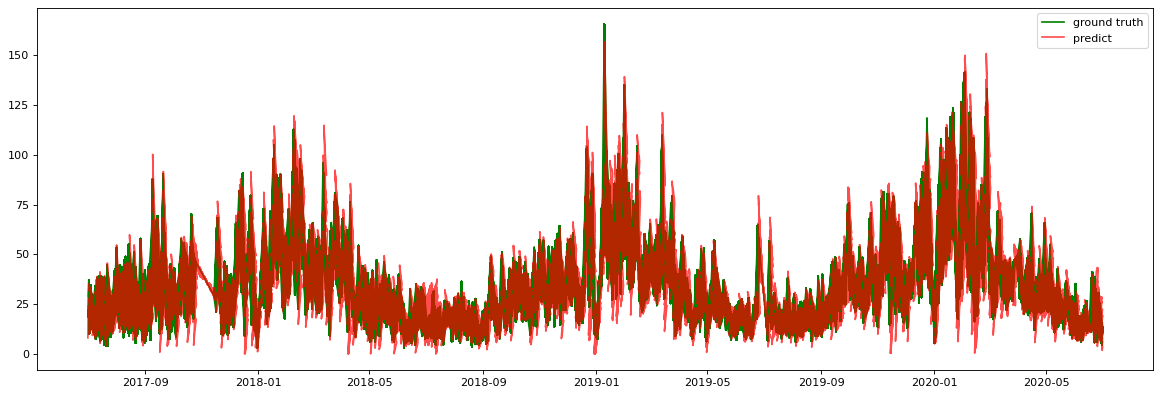

In [11]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

#### Dump PM2.5 model and exog models

In [12]:
with open('./model_save/saraburi/model_sara.model',"wb") as f:
    pickle.dump(model, f)

with open('./model_save/saraburi/model_sara_exog.model',"wb") as f:
    pickle.dump(model_exog, f)

#### Load PM2.5 model and exog models

In [13]:
model = pickle.load(open('./model_save/saraburi/model_sara.model', 'rb'))
model_exog = pickle.load(open('./model_save/saraburi/model_sara_exog.model', 'rb'))

### Predict on test set

In [14]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [09:24<00:00,  4.92it/s]

ITER#0  RMSE:11.401123102735975


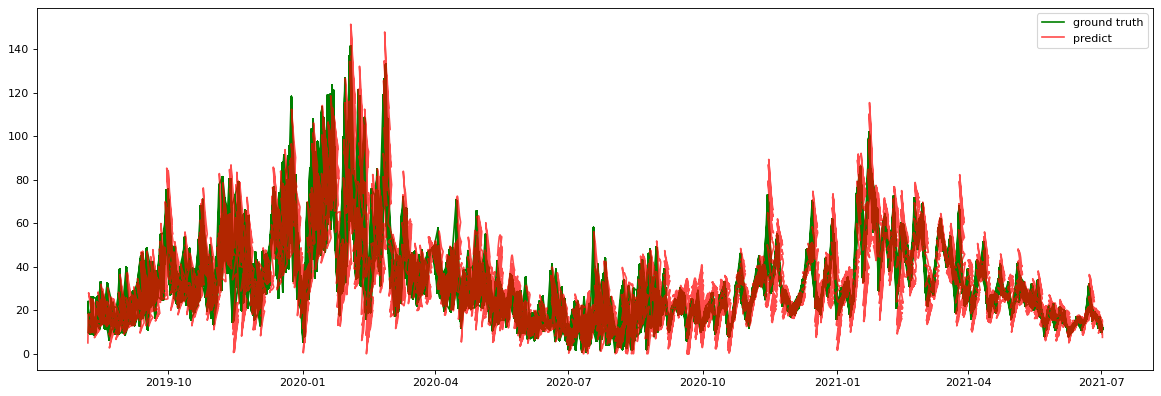

In [15]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [16]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_SARA.csv')